In [172]:
import torch
import torch.nn.functional as F

In [259]:
# SETUP CONSTANTS

from util import get_names, PAD, ctoi, itoc, N_CHARS

CONTEXT: int = 10
EMBEDDING_WIDTH: int = 2
HIDDEN_WIDTH: int = 500
# DEVICE = 'cpu'
# DEVICE = 'mps'
DEVICE = 'cuda'

names = get_names()
len(names)



# PREP DATA

def get_xs_and_ys():
    padding = PAD * CONTEXT # e.g. '.....'
    n = CONTEXT + 1

    # xs = []
    # ys = []
    # for name in names:
    #     name = padding + name + padding
    #     sets = [list(name[i:i+n]) for i in range(len(name) - n * 2 + 3)]
    #     for set in sets:
    #         xs.append(set[:-1])
    #         ys.append(set[-1])
    # return (xs, ys)

    xlist: list[list[int]] = []
    ylist: list[int] = []

    for name in names:
        name = padding + name + padding
        sets = [list(name[i:i+n]) for i in range(len(name) - n * 2 + 3)]
        for set in sets:
            xlist.append([ctoi[c] for c in set[:-1]])
            ylist.append(ctoi[set[-1]])

    xs = torch.tensor(xlist, dtype=torch.int64).to(device=DEVICE)
    # xs = F.one_hot(xs, N_CHARS).float()
    ys = torch.tensor(ylist, dtype=torch.int64).to(device=DEVICE)

    return (xs, ys)

xs, ys = get_xs_and_ys()

split = int(xs.shape[0] * 0.5)
xs_test = xs[split:]
ys_test = ys[split:]
xs = xs[:split]
ys = ys[:split]

print(xs.shape)
print(ys.shape)
print(xs_test.shape)
print(ys_test.shape)
print(xs[:5].cpu().numpy())
print(ys[:5].cpu().numpy())

M = ys.shape[0]
print(M)



# INITIALIZE MODEL

EmbeddingMatrix = torch.randn(N_CHARS, EMBEDDING_WIDTH).to(device=DEVICE) # will be ran once for each context character
# The output is concatenated along the embedding dim before passing to the hidden layer
print(EmbeddingMatrix.shape)

W1 = torch.randn([CONTEXT * EMBEDDING_WIDTH, HIDDEN_WIDTH]).to(device=DEVICE)
print(W1.shape)
B1 = torch.randn([1, HIDDEN_WIDTH]).to(device=DEVICE)

W2 = torch.randn([HIDDEN_WIDTH, N_CHARS]).to(device=DEVICE)
print(W2.shape)
B2 = torch.randn([1, N_CHARS]).to(device=DEVICE)

params = [EmbeddingMatrix, W1, B1, W2, B2]

for p in params:
    p.requires_grad = True
    
param_count = sum([param.numel() for param in params])
print(f"param count: {param_count}")

losses = []

name count: 6782
torch.Size([23494, 10])
torch.Size([23494])
torch.Size([23494, 10])
torch.Size([23494])
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0 10 15]
 [ 0  0  0  0  0  0  0 10 15  8]
 [ 0  0  0  0  0  0 10 15  8 14]]
[10 15  8 14  0]
23494
torch.Size([27, 2])
torch.Size([20, 500])
torch.Size([500, 27])
param count: 24081


In [273]:
for _ in range(100):
    # FORWARD
    # TODO: Eliminate cat by using multidimentional indexing and view instead. Building Makemore pt. 2 @ 16:30
    embeddings = EmbeddingMatrix[xs].view(M, CONTEXT * EMBEDDING_WIDTH)
    # embeddings = torch.cat([xs[:, i_context, :] @ EmbeddingMatrix for i_context in range(CONTEXT)], dim=1)
    # print(embeddings.shape)
    # print(embeddings[0][0])

    hidden_output = torch.tanh(embeddings @ W1 + B1)
    # print(hidden_output.shape)

    logits = hidden_output @ W2 + B2
    # print(logits.shape)

    loss = F.cross_entropy(logits, ys)
    losses.append(loss.item())
    # print(loss.item())

    # LOSS
    # counts = logits.exp()
    # prob = counts / counts.sum(dim=1, keepdim=True)
    # loss = - prob[torch.arange(M, dtype=torch.int64), ys].log().mean()
    # print(loss)

    # BACKWARD
    for p in params:
        p.grad = None
    loss.backward()

    # STEP
    for p in params:
        p.data += -0.01* p.grad # type: ignore

print(f"Train Loss: {losses[-1]:.4}")


embeddings = EmbeddingMatrix[xs_test].view(-1, CONTEXT * EMBEDDING_WIDTH)
hidden_output = torch.tanh(embeddings @ W1 + B1)
logits = hidden_output @ W2 + B2
test_loss = F.cross_entropy(logits, ys_test)

print(f"Test Loss: {test_loss.item():.4}")

Train Loss: 2.557
Test Loss: 2.631


In [274]:
# Predict

for i in range(25):
    name = PAD * CONTEXT

    while name[-1] != PAD or len(name) == CONTEXT:
        _xs = torch.tensor([ctoi[c] for c in name[-CONTEXT:]]).unsqueeze(dim=0)
        # print(xs.shape)

        embeddings = EmbeddingMatrix[_xs].view(_xs.shape[0], CONTEXT * EMBEDDING_WIDTH)
        # print(embeddings.shape)

        hidden_output = torch.tanh(embeddings @ W1 + B1)
        # print(hidden_output.shape)

        logits = hidden_output @ W2 + B2

        probs = F.softmax(logits)

        i = int(torch.multinomial(probs, 1, replacement=True).item())

        name += itoc[i]

    name = name.strip('.')
    print(name)

canjie
jauvea
devtalg
lucho
trirhin
waotac
crcoy
zrgherfe
alyc
mezs
hanaris
grsao
alfrm
plankerl
rava
reinr
tapbu
seyey
maloal
aalcyrdsno
hebeon
cutb
qiriar
war
talk


C:\Users\spens\AppData\Local\Temp\ipykernel_7516\1375464737.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)


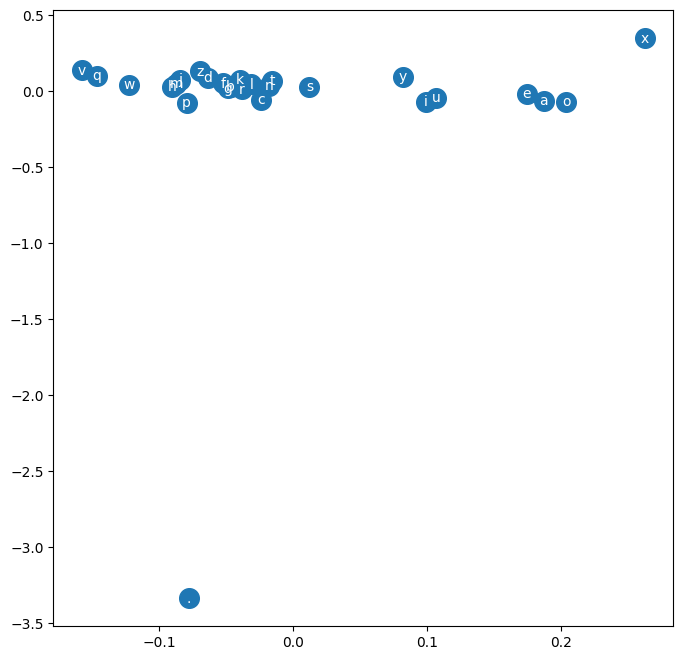

In [275]:
import matplotlib.pyplot as plt

C = EmbeddingMatrix

plt.figure(figsize=(8, 8))
cmap = 'inferno' # 'viridis' 'rainbow'
s = 200
x = C[:, 0].data.cpu()
y = C[:, 1].data.cpu() if EMBEDDING_WIDTH > 1 else torch.tensor([0 for _ in range(N_CHARS)])

if EMBEDDING_WIDTH > 2:
    z = C[:, 2].data.cpu()
    plt.scatter(x, y, s=200, c=z) # rainbow
else:
    plt.scatter(x, y, s=s)

for i in range(N_CHARS):
    plt.text(x[i].item(), y[i].item(), itoc[i], ha="center", va="center", color="white")
# plt.grid('minor')